In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [22]:
df=pd.read_csv('training.csv')
df = df[df.topic != 'IRRELEVANT']
#make all strings
df['article_words']=df['article_words'].apply(str)

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df['article_words_parse_1'] = df['article_words']

for punct_sign in punctuation_signs:
    df['article_words_parse_1'] = df['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df['article_words_parse_2'] = df['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df['Category_Code'] = df['topic']
df = df.replace({'Category_Code':category_codes})


df = df.drop(["article_words", "article_words_parse_1"], axis=1)


print(df)

      article_number                             topic  \
0                  1                     FOREX MARKETS   
1                  2                     MONEY MARKETS   
2                  3                            SPORTS   
3                  4                     FOREX MARKETS   
5                  6                    SHARE LISTINGS   
...              ...                               ...   
9491            9492  BIOGRAPHIES PERSONALITIES PEOPLE   
9492            9493                     MONEY MARKETS   
9495            9496                           DEFENCE   
9497            9498                     FOREX MARKETS   
9499            9500                     FOREX MARKETS   

                                  article_words_parse_2  Category_Code  
0     open absent cent cent cent stock inflow rate k...              4  
1     morn stead end end day day day patch patch pat...              7  
2     socc socc world world recent law fifa fifa fif...             10  
3     open 

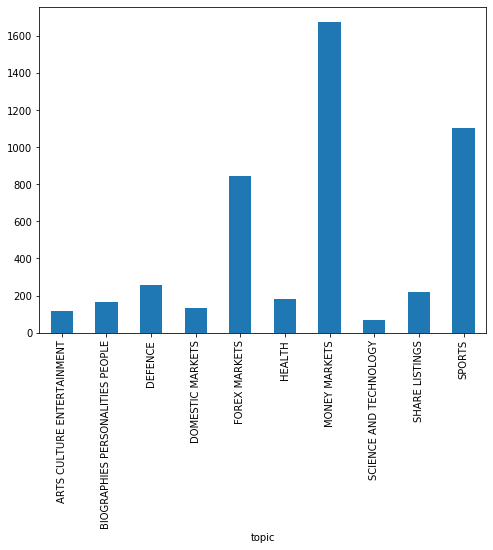

In [23]:
#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('topic').article_words_parse_2.count().plot.bar(ylim=0)
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['article_words_parse_2'], 
                                                    df['Category_Code'],
                                                    test_size=0.2, 
                                                    random_state=8)

print(X_train)

3594    open divid afric hit length length contin cont...
2604    quart quart beat cup cup halftim sunday st old...
5505    provid recent stock cap file file sb action na...
5159    divid open reschedul world world world world w...
672     flow contrast research afric afric afric purch...
                              ...                        
4251    hope provid reinforc bulwark rate rate rate ra...
4669    hit hope rate rate rate rate sooth recent sout...
3989    load carg march march march march march march ...
2678    tend stabl stabl morn cent cent recent inflow ...
9059    bond dollar dollar gbp jpy april canad canad c...
Name: article_words_parse_2, Length: 3812, dtype: object


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 4000

tfidf = TfidfVectorizer(encoding='utf-8',
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(3812, 3811)
(954, 3811)


In [10]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [26]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [27]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Stephen Sung\Anaconda3\lib\site-pa

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight':

In [28]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.30000000000000004}

The mean accuracy of a model with these hyperparameters is:
0.7749213011542497


In [29]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['lbfgs']
class_weight = [None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [30]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

The mean accuracy of a model with these hyperparameters is:
0.7538420773714891


In [31]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:

best_lrc.fit(features_train, labels_train)

lrc_pred = best_lrc.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))


# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The training accuracy is: 
0.9042497376705142
The test accuracy is: 
0.7714884696016772


In [33]:

# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.77      0.38      0.51        26
           1       0.71      0.53      0.61        32
           2       0.86      0.98      0.91        43
           3       0.96      0.80      0.87        30
           4       0.52      0.43      0.47       175
           5       0.84      0.91      0.88        35
           7       0.72      0.79      0.75       333
           8       1.00      0.47      0.64        17
           9       0.98      1.00      0.99        50
          10       0.92      1.00      0.96       213

    accuracy                           0.77       954
   macro avg       0.83      0.73      0.76       954
weighted avg       0.76      0.77      0.76       954



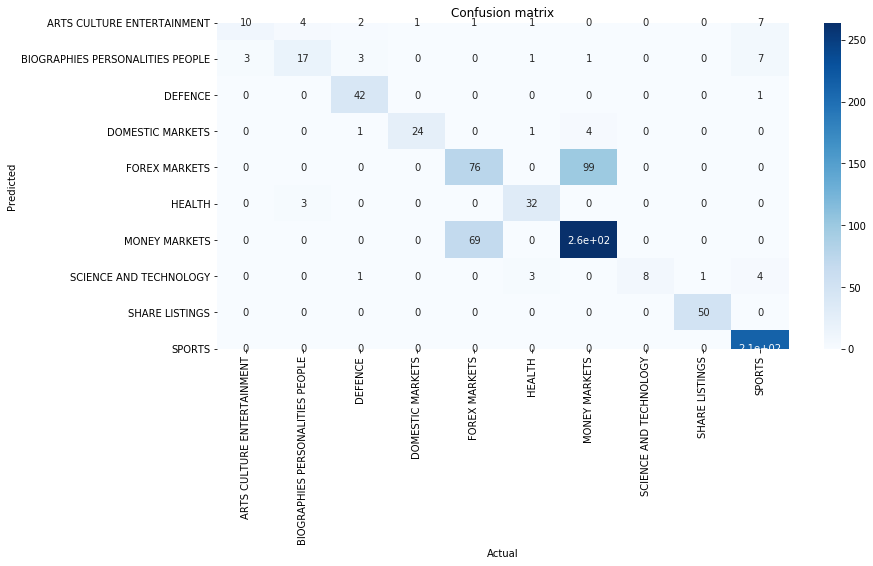

In [34]:
aux_df = df[['topic', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [35]:
check_df1[check_df1.prediction == 'ARTS CULTURE ENTERTAINMENT'].shape[0]

NameError: name 'check_df1' is not defined